In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [2]:
class TspTw:
    def __init__(self, file: str, base=1000):
        self.base = base

        with open(input_file, "r") as file:
            self.num_nodes = int(next(file).rstrip("\n"))
            self.depot = 0

            self.service_times = []
            self.distance_matrix = [[0.0 for _ in range(self.num_nodes)] for _ in range(self.num_nodes)]
            for i in range(self.num_nodes):
                words = next(file).rstrip("\n").split()
                service_time = float(words[i])
                self.service_times.append(service_time)
                for j in range(self.num_nodes):
                    self.distance_matrix[i][j] = float(words[j])

            # time matrix には出発地点の service time が含まれている
            for i in range(self.num_nodes):
                for j in range(self.num_nodes):
                    self.distance_matrix[i][j] -= self.service_times[i]

            self.time_windows = []
            for i in range(self.num_nodes):
                words = next(file).rstrip("\n").split()
                self.time_windows.append((int(words[0]), int(words[1])))

    @property
    def nodes(self) -> list[int]:
        return list(range(self.num_nodes))
        
    def scaled_dist(self, i, j) -> int:
        return int(self.distance_matrix[i][j] * self.base)

    def scaled_tw(self, i) -> int:
        st, ed = self.time_windows[i]
        return (int(st * self.base), int(ed * self.base))

    def scaled_st(self, i) -> int:
        return int(self.service_times[i] * self.base)

In [3]:
class Model:
    def __init__(self, tsp: TspTw):
        self.tsp = tsp
        self.manager = pywrapcp.RoutingIndexManager(self.tsp.num_nodes, 1, self.tsp.depot)
        self.routing = pywrapcp.RoutingModel(self.manager)
        self.transit_callback_index = self.routing.RegisterTransitCallback(self.time_callback)
        # self.transit_callback_index = self.routing.RegisterTransitCallback(lambda from_index, to_index: 1)
        self.routing.SetArcCostEvaluatorOfAllVehicles(self.transit_callback_index)
        
        time = "Time"
        self.routing.AddDimension(
            self.transit_callback_index,
            30,  # allow waiting time
            30,  # maximum time per vehicle
            False,  # Don't force start cumul to zero.
            time,
        )
        time_dimension = self.routing.GetDimensionOrDie(time)
        # Add time window constraints for each location except depot.
        for i in self.tsp.nodes:
            if i == self.tsp.depot:
                continue
            tw_start, tw_end = self.tsp.scaled_tw(i)
            print(f"node {i} : [{tw_start}, {tw_end}]")
            index = self.manager.NodeToIndex(i)
            time_dimension.CumulVar(index).SetRange(tw_start, tw_end)

        index = self.routing.Start(0)
        time_dimension.CumulVar(index).SetRange(self.tsp.scaled_tw(self.tsp.depot)[0], self.tsp.scaled_tw(self.tsp.depot)[1])

        self.routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(self.routing.Start(0))
        )
        self.routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(self.routing.End(0)))

    def time_callback(self, from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = self.manager.IndexToNode(from_index)
        to_node = self.manager.IndexToNode(to_index)
        return self.tsp.scaled_dist(from_node, to_node)

    def solve(self):
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        # search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        # search_parameters.time_limit.seconds = 10
        # search_parameters.log_search = True
        return self.routing.SolveWithParameters(search_parameters)

    def print_solution(self, solution):
        """Prints solution on console."""
        print(f"Objective: {solution.ObjectiveValue() / self.tsp.base}")
        index = self.routing.Start(0)
        plan_output = "Route:\n"
        route_distance = 0
        while not self.routing.IsEnd(index):
            plan_output += f" {self.manager.IndexToNode(index)} ->"
            previous_index = index
            index = solution.Value(self.routing.NextVar(index))
            route_distance += self.routing.GetArcCostForVehicle(previous_index, index, 0)
        plan_output += f" {self.manager.IndexToNode(index)}\n"
        print(plan_output)
        plan_output += f"Objective: {route_distance}m\n"

In [4]:
input_file = "../data/SolomonPotvinBengio/rc_206.1.txt"
# input_file = "../data/SolomonPotvinBengio/rc_206.3.txt"
# input_file = "../data/Langevin/N20ft301.dat"
# input_file = "../data/Langevin/N40ft201.dat"
# input_file = "../data/Dumas/n200w20.001.txt"
tsp = TspTw(input_file)

In [5]:
print("Distance matrix(scaled)")
for i in tsp.nodes:
    for j in tsp.nodes:
        print(tsp.scaled_dist(i, j), end=' ')
    print()

print("\nService time(scaled)")
print([int(tsp.scaled_st(i)) for i in tsp.nodes])

print("\nTime window(scaled)")
print([tsp.scaled_tw(i) for i in tsp.nodes])

Distance matrix(scaled)
0 43011 36055 33541 
43011 0 7071 11180 
36055 7071 0 5000 
33541 11180 5000 0 

Service time(scaled)
[0, 10000, 10000, 10000]

Time window(scaled)
[(0, 960000), (43000, 283000), (36000, 276000), (33000, 273000)]


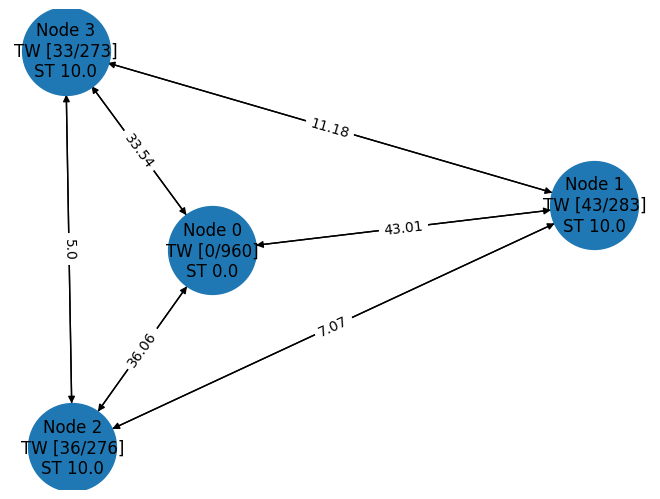

In [6]:
graph = nx.DiGraph()
for i in tsp.nodes:
    for j in tsp.nodes:
        if j >= i:
            continue
        weight = round(tsp.distance_matrix[i][j], 2)
        graph.add_edge(i, j, weight=weight)
        graph.add_edge(j, i, weight=weight)
node_labels = {}
for i in tsp.nodes:
    node_labels[i] = f"Node {i}\nTW [{tsp.time_windows[i][0]}/{tsp.time_windows[i][1]}]\nST {tsp.service_times[i]}"

pos = nx.spring_layout(graph, seed=0)
labels = nx.get_edge_attributes(graph, "weight")
nx.draw(graph, pos, node_size=400*10, labels=node_labels)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.show()

In [7]:
model = Model(tsp)
solution = model.solve()

node 1 : [43000, 283000]


Exception: CP Solver fail

In [ ]:
model.print_solution(solution)

In [ ]:
solution